<a href="https://colab.research.google.com/github/astepankoff/gigachat_tutorials/blob/main/RAG_%D0%BF%D0%BE_%D1%81%D1%82%D0%B0%D1%82%D1%8C%D1%8F%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание простой вопросно-ответной системы
## Что из себя представляют вопросно-ответные системы с использованием языковых моделей

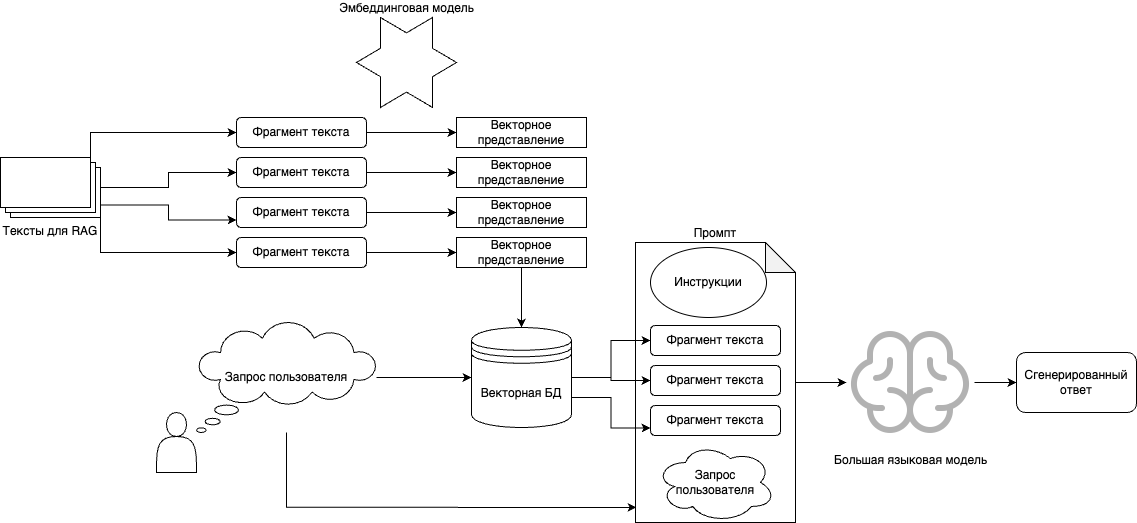

## Установка требуемых библиотек

В рамках туториала нам потребуется некоторое количество инструментов:
- `gigachain` - основной инструмент построения пайплайнов с большими языковыми моделями;
- `faiss-cpu` - используем векторное хранилище FAISS для размещения чанков (фрагментов текстов для контекста)и эмбеддингов (векторных представлений) этих чанков;
- `sentence-transformers` - библиотека для локального использования эмбеддинговых моделей с ресурса Hugging Face;
- `rank_bm25` - библиотека для работы с алгоритмами векторизации BM25 (вариации TF-IDF);
- `playwright` - библиотека для автоматизации браузера, в нашем случае для парсинга списка статей с веб-сайта.

In [4]:
!pip install langchain-gigachat langchain-community faiss-cpu sentence-transformers rank_bm25 playwright --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00


Также выполним установку браузера для сбора списка статей.

In [3]:
!playwright install

172.5 MiB [] 0% 0.0s172.5 MiB [] 0% 8.2s172.5 MiB [] 0% 6.0s172.5 MiB [] 0% 5.4s172.5 MiB [] 1% 5.1s172.5 MiB [] 1% 4.9s172.5 MiB [] 1% 5.0s172.5 MiB [] 2% 4.7s172.5 MiB [] 2% 4.6s172.5 MiB [] 3% 4.2s172.5 MiB [] 3% 4.0s172.5 MiB [] 4% 3.9s172.5 MiB [] 4% 3.8s172.5 MiB [] 5% 4.3s172.5 MiB [] 5% 4.4s172.5 MiB [] 5% 4.3s172.5 MiB [] 6% 4.4s172.5 MiB [] 6% 4.3s172.5 MiB [] 7% 4.2s172.5 MiB [] 7% 4.1s172.5 MiB [] 8% 4.0s172.5 MiB [] 8% 3.9s172.5 MiB [] 8% 4.0s172.5 MiB [] 9% 3.9s172.5 MiB [] 10% 3.7s172.5 MiB [] 10% 3.6s172.5 MiB [] 11% 3.6s172.5 MiB [] 12% 3.5s172.5 MiB [] 13% 3.4s172.5 MiB [] 14% 3.3s172.5 MiB [] 14% 3.2s172.5 MiB [] 15% 3.1s172.5 MiB [] 16% 3.0s172.5 MiB [] 16% 3.1s172.5 MiB [] 17% 3.0s172.5 MiB [] 18% 3.0s172.5 MiB [] 18% 2.9s172.5 MiB [] 19% 2.8s172.5 MiB [] 20% 2.8s172.5 MiB [] 21% 2.7s172.5 MiB [] 22% 2.6s172.5 MiB [] 24% 2.4s172.5 MiB [] 25% 2.3s172.5 MiB [] 26% 2.2s172.5 MiB [] 28% 2.1s172.5 MiB [] 29% 2.0s172.5 MiB [] 31% 1.9s172.5 MiB [] 32% 1.8s172.5 MiB [] 34%

## Выполним сбор статей
В качестве источника знаний используем статьи с научно-популярного сайта [N + 1](https://nplus1.ru/). Возьмем последние статьи по космонавтике.

Используем `AsyncChromiumLoader` из GigaChain для загрузки страницы. Этот инструмент приходится использовать, потому что выборка статей по направлениям подгружает перечень статей не сразу, а значит получить его обычным запросом `requests.get()` не получится.

Из-за асинхронной работы `AsyncChromiumLoader` сделаем сбор статей отдельным скриптом.

В результате выполнения скрипта мы получим отдельный текстовый файл со ссылками на статьи по космической тематике.

In [5]:
%%writefile parser.py

from langchain_community.document_loaders import AsyncChromiumLoader
from bs4 import BeautifulSoup

# Инициализируем загрузчик
loader = AsyncChromiumLoader(["https://nplus1.ru/search?tags=871"])
html = loader.load()
articles = 'n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24'
with open('page.html', 'w') as f:
  f.write(html[0].page_content)
soup = BeautifulSoup(html[0].page_content, 'html.parser')
links = []
with open('links.txt', 'w') as f:
  for link in soup.find_all('a', class_=articles):
    print(link)
    links.append(link['href'])
    f.write(link['href']+' ')


Writing parser.py


In [6]:
!python parser.py

USER_AGENT environment variable not set, consider setting it to identify your requests.
<a class="n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24" href="https://nplus1.ru/news/2025/08/20/start-bion-m-2"><div>Начался полет второго биоспутника «Бион-М»</div><!-- --></a>
<a class="n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24" href="https://nplus1.ru/news/2025/06/30/h-iia-final"><div>Японская ракета H-IIA совершила финальный полет в космос</div><!-- --></a>
<a class="n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24" href="https://nplus1.ru/news/2025/06/11/punch-first-cme"><div>Зонды PUNCH увидели свои первые корональные выбросы</div><!-- --></a>
<a class="n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24" href="https://nplus1.ru/news/2025/05/30/psych

## Подготовка фрагментов статей, векторизация и загрузка в векторную БД

Откроем файл со ссылками.

In [7]:

with open('links.txt') as f:
  sources = f.read()

print(sources.split())


['https://nplus1.ru/news/2025/08/20/start-bion-m-2', 'https://nplus1.ru/news/2025/06/30/h-iia-final', 'https://nplus1.ru/news/2025/06/11/punch-first-cme', 'https://nplus1.ru/news/2025/05/30/psyche-now-work-again', 'https://nplus1.ru/news/2025/05/28/starship-9-end', 'https://nplus1.ru/news/2025/05/08/resilience-lunar-orbit', 'https://nplus1.ru/news/2025/04/14/new-shepard-ns-31', 'https://nplus1.ru/news/2025/08/11/luna-27-29', 'https://nplus1.ru/news/2025/06/25/resilience-fail-lidar', 'https://nplus1.ru/news/2025/06/06/tianwen-2-first-photo', 'https://nplus1.ru/news/2025/05/29/firefly-aerospace-rashid-2', 'https://nplus1.ru/news/2025/05/23/interlune-lunar-harvester', 'https://nplus1.ru/news/2025/04/30/kuiper-start', 'https://nplus1.ru/news/2025/04/05/fram-2-end', 'https://nplus1.ru/news/2025/08/06/lunar-trailblazer-end', 'https://nplus1.ru/news/2025/06/25/axiom-4', 'https://nplus1.ru/news/2025/06/06/resilience-moon', 'https://nplus1.ru/news/2025/05/28/tianwen-2-launch', 'https://nplus1.r

Импортируем нужные инструменты.


In [8]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores.faiss import FAISS
from langchain_core.documents import Document

In [9]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

Осуществим загрузку веб-страниц по ссылкам.

In [10]:
loader = WebBaseLoader(sources.split())

In [11]:
docs = loader.load()

In [12]:
len(docs)

28

Разделим тексты статей на фрагменты длиной 500 символов и перекрытием в 100 символов.

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,
                                              chunk_overlap=100)
split_docs = text_splitter.split_documents(docs)

In [14]:
len(split_docs)

383

In [15]:
split_docs[1]

Document(metadata={'source': 'https://nplus1.ru/news/2025/08/20/start-bion-m-2', 'title': 'Начался полет второго биоспутника «Бион-М». Он\xa0проведет 30\xa0дней на\xa0полярной орбите', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Авторам\n              \n\n\nИгры\nФизика\nЗоология\nАстрономия\nГенетика\nМатематика\n\n\nКосмонавтика\nАрхеология\nНейронауки\nНа мышах\nЗвук\nКрасота\n\n\nНаучные закрытия\nИИ спешит на помощь\nКогда рассеется дым\nКнижная полка\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                О нас\n              \n\n                Сложность\n              \n\n                Рекламодателям\n              \n\n                Авторам')

Создадим ретривер и векторное хранилище для врагментов текста.

- [Рейтинг ретриверов для английского языка](https://huggingface.co/spaces/mteb/leaderboard)
- [Рейтинг ретриверов для русского языка](https://github.com/avidale/encodechka#%D0%BB%D0%B8%D0%B4%D0%B5%D1%80%D0%B1%D0%BE%D1%80%D0%B4)
- [Эмбеддинговая модель, которую используем в этом туториале](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2)

In [16]:
%%time
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embedding = HuggingFaceEmbeddings(model_name=model_name,
                                  model_kwargs=model_kwargs,
                                  encode_kwargs=encode_kwargs)

vector_store = FAISS.from_documents(split_docs, embedding=embedding)

<timed exec>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

CPU times: user 2min 2s, sys: 13.1 s, total: 2min 15s
Wall time: 2min 30s


Зададим параметры извлечения. В нашем случае установим, что на запрос должны возвращаться 5 фрагментов, наиболее близких по смыслу.

In [17]:
embedding_retriever = vector_store.as_retriever(search_kwargs={"k": 5})

## Создание генеративной части пайплайна и составление цепочки RAG системы

Используем авторизационные данные для подключения к GigaChat API.

In [18]:
from google.colab import userdata
auth = userdata.get('SBER_AUTH')

Импортируем необходимые компоненты

In [19]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models.gigachat import GigaChat
from langchain.chains import create_retrieval_chain

Создадим объект `GigaChat` и подготовим промпт для вопросно-ответной системы.

In [20]:

llm = GigaChat(credentials=auth,
              model='GigaChat:latest',
               verify_ssl_certs=False,
               profanity_check=False)
prompt = ChatPromptTemplate.from_template('''Ответь на вопрос пользователя. \
Используй при этом только информацию из контекста. Если в контексте нет \
информации для ответа, сообщи об этом пользователю.
Контекст: {context}
Вопрос: {input}
Ответ:'''
)

/tmp/ipython-input-250286326.py:1: LangChainDeprecationWarning: The class `GigaChat` was deprecated in LangChain 0.3.5 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-gigachat package and should be used instead. To use it run `pip install -U :class:`~langchain-gigachat` and import as `from :class:`~langchain_gigachat import GigaChat``.
  llm = GigaChat(credentials=auth,


Создадим цепочку `create_stuff_documents_chain`, которая будет частью нашей вопросно-ответной цепочки. Это нужно, чтобы подавать фрагменты текстов из векторной БД в промпт языковой модели. Промпт представляет из себя форматированную строку, а франменты являются экземплярами класса `Document`. Чтобы не писать код по извлечению атрибута `page_content` из `Document`, используем цепочку `create_stuff_documents_chain`, где это автоматизировано.

In [21]:
document_chain = create_stuff_documents_chain(
    llm=llm,
    prompt=prompt
    )

А теперь создадим вопросно-ответную цепочку с помощью функции `create_retrieval_chain()`.

In [22]:
retrieval_chain = create_retrieval_chain(embedding_retriever, document_chain)

## Запустим нашу вопросно-ответную систему

Пусть RAG-система ответит на следующие 5 вопросов:
- Какие космические аппараты запускал Китай к Луне?
- Когда Хаббл вернулся к работе?
- Какая есть информация о неудачных запусках?
- Есть ли какая-то информация, связанная с именем древнегреческого математика?
- Дай информацию, связанную с лазерами.

In [23]:
q1 = 'Какие космические аппараты запускал Китай к Луне?'

In [24]:
resp1 = retrieval_chain.invoke(
    {'input': q1}
)

In [25]:
resp1

{'input': 'Какие космические аппараты запускал Китай к Луне?',
 'context': [Document(id='2581efc6-fe71-41ed-8ac2-ce948cea58ef', metadata={'source': 'https://nplus1.ru/news/2025/06/06/tianwen-2-first-photo', 'title': 'Станция «Тяньвэнь-2» прислала первый снимок из\xa0космоса. На\xa0него попала одна из\xa0солнечных батарей', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Александр Войтюк\n\n\n\nКитайская межпланетная станция «Тяньвэнь-2» прислала первый снимок из\xa0космоса, полученный 6\xa0июня 2025\xa0года, когда аппарат находился на\xa0удалении более трех миллионов километров от\xa0Земли. В кадр попала одна из\xa0полностью развернутых круглых солнечных батарей.'),
  Document(id='9abd60dc-66cf-4e20-9949-31b3b74505a9', metadata={'source': 'https://nplus1.ru/news/2025/05/28/tianwen-2-launch', 'title': 'Китай запустил станцию «Тяньвэнь-2» для добычи грунта с\xa0квазиспутника Земли. Аппарат также посетит ядро кометы Главного пояса'

In [26]:
q2 = 'Когда Хаббл вернулся к работе?'

In [27]:
resp2 = retrieval_chain.invoke(
    {'input': q2}
)

In [28]:
resp2

{'input': 'Когда Хаббл вернулся к работе?',
 'context': [Document(id='a31b711a-d891-473b-95f0-3db9dcdaa6cb', metadata={'source': 'https://nplus1.ru/news/2025/05/20/ikaros-end', 'title': 'JAXA прекратило попытки связаться с\xa0первым межпланетным аппаратом на\xa0солнечном парусе. IKAROS был запущен в\xa0космос в\xa02010 году', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='вошел в\xa0режим гибернации из-за проблем с\xa0ориентацией, вызванных нехваткой топлива. Ожидалось, что он\xa0проснется зимой того\xa0же года, однако этого не\xa0произошло, а\xa0дальнейшие попытки установления связи не\xa0принесли результатов.'),
  Document(id='c896ba6b-f675-405e-9a9e-86d407f058c2', metadata={'source': 'https://nplus1.ru/news/2025/06/06/resilience-moon', 'title': 'Японский частный модуль Resilience совершил жесткую посадку на\xa0Луну. Связи с\xa0модулем нет, поэтому миссию завершили', 'description': 'N + 1 — главное издание о науке, технике и 

In [29]:
q3 = 'Какая есть информация о неудачных запусках?'

In [30]:
resp3 = retrieval_chain.invoke(
    {'input': q3}
)

In [31]:
resp3

{'input': 'Какая есть информация о неудачных запусках?',
 'context': [Document(id='ec3cf64c-8892-4a47-8f91-31b7320c49b6', metadata={'source': 'https://nplus1.ru/news/2025/05/28/starship-9-end', 'title': 'Девятый полет Starship кончился взрывом обеих ступеней на\xa0этапе возвращения. Это была первая попытка повторного использования первой ступени системы', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Предыдущие два испытательных полета ракеты завершились похожим результатом\xa0— первые ступени успешно вернулись на\xa0стартовую площадку и\xa0были пойманы манипуляторами на\xa0башне обслуживания, в\xa0то\xa0время как вторым ступеням не\xa0удалось попасть набрать высоту для выхода в\xa0космос. В\xa0случае седьмого полета авария произошла из-за утечки кислорода или метана в\xa0полости над защитной перегородкой одного из\xa0двигателей второй ступени. В\xa0случае восьмого полета вначале произошел отказ центрального двигателя второй')

In [32]:
q4 = 'Есть ли какая-то информация, связанная с именем древнегреческого математика?'

In [33]:
resp4 = retrieval_chain.invoke(
    {'input': q4}
)

In [34]:
resp4

{'input': 'Есть ли какая-то информация, связанная с именем древнегреческого математика?',
 'context': [Document(id='7a748e56-a18c-4006-98e1-e7c447577628', metadata={'source': 'https://nplus1.ru/news/2025/06/11/punch-first-cme', 'title': 'Зонды PUNCH увидели свои первые корональные выбросы. Четыре аппарата вели непрерывные наблюдения за\xa0короной Солнца', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='помощи узкоугольной камеры и\xa0коронографической маски отслеживал более детально структуру выбросов, блокируя излучение диска Солнца. В\xa0результате сшивания изображений в\xa0единую анимацию можно в\xa0подробностях изучать эволюцию распространения солнечной плазмы в\xa0межпланетном пространстве. На\xa0отдельные кадры также попали Венера, Юпитер, Луна, ряд созвездий, включая Орион, и\xa0рассеянное скопление Плеяды.'),
  Document(id='34e278f4-dcf8-4fc8-a065-8e22ba850047', metadata={'source': 'https://nplus1.ru/news/2025/04/14/new-

In [35]:
q5 = "Дай информацию, связанную с лазерами."

In [36]:
resp5 = retrieval_chain.invoke(
    {'input': q5}
)

In [37]:
resp5

{'input': 'Дай информацию, связанную с лазерами.',
 'context': [Document(id='02c6e453-3cbd-4eb2-a237-3ce82cab7b02', metadata={'source': 'https://nplus1.ru/news/2025/04/30/spherex-first-photos', 'title': 'Инфракрасная обсерватория SPHEREx прислала первые снимки из\xa0космоса. Она составит четыре атласа неба за\xa0два года работы', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Первые неоткалиброванные снимки SPHEREx были получены 27 марта 2025 года в рамках процедуры ввода в эксплуатацию, которая, как и процедура завершения работы обсерватории, занимает один месяц. Каждый из шести снимков соответствует одному из детекторов обсерватории и содержит около десяти тысяч источников излучения, таких как звезды и галактики. Изображения говорят о том, что процедура фокусировки проведена правильно. Научные наблюдения начнутся после завершения процедуры калибровки и пассивного'),
  Document(id='7a748e56-a18c-4006-98e1-e7c447577628', metada

## Использование ретривера BM25

Теперь для векторизации фрагментов и запроса пользователя используем более простую модель. Модели BM25 основана на векторизации TF-IDF. То есть в отличие от эмбеддинговой модели, где вектор представляет собой числовое представление семантического смысла, модели BM25 векторизируют текст по словам. Можно сказать, что поиск с помощью BM25 - это поиск по ключевым словам.

Поскольку BM25 работает со словами, а не со смыслами, нужно как в классическом NLP выполнить предобработку текстов, чтобы уменьшить словарь.

In [38]:
import string


def tokenize(s):
    return s.lower().translate(str.maketrans("", "", string.punctuation)).split(" ")

In [39]:
bm25_retriever = BM25Retriever.from_documents(
      documents=split_docs,
      preprocess_func=tokenize,
      k=5,
  )

In [40]:
bm25_retriever.get_relevant_documents(q5)

/tmp/ipython-input-2130443268.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  bm25_retriever.get_relevant_documents(q5)


[Document(metadata={'source': 'https://nplus1.ru/news/2025/08/20/start-bion-m-2', 'title': 'Начался полет второго биоспутника «Бион-М». Он\xa0проведет 30\xa0дней на\xa0полярной орбите', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='20 августа 2025 года в 20:13 по московскому времени ракета-носитель «Союз-2.1б» успешно стартовала с космодрома Байконур с аппаратом «Бион-М» 2 и вывела его на околоземную орбиту с наклонением почти 97 градусов и высотой около 370–380 километров. Полет продлится 30 дней, на борту аппарата находятся черные мыши линии C57BL/6, мухи дрозофилы, муравьиная ферма, мхи, образцы растений, штаммы микроорганизмов и культуры клеток. После полета извлеченные из капсулы мыши будут сравниваться с'),
 Document(metadata={'source': 'https://nplus1.ru/news/2025/04/30/spherex-first-photos', 'title': 'Инфракрасная обсерватория SPHEREx прислала первые снимки из\xa0космоса. Она составит четыре атласа неба за\xa0два года 

In [41]:
bm25_chain = create_retrieval_chain(bm25_retriever, document_chain)

In [42]:
resp5_2 = bm25_chain.invoke(
    {'input': q5}
)

In [43]:
resp5_2

{'input': 'Дай информацию, связанную с лазерами.',
 'context': [Document(metadata={'source': 'https://nplus1.ru/news/2025/08/20/start-bion-m-2', 'title': 'Начался полет второго биоспутника «Бион-М». Он\xa0проведет 30\xa0дней на\xa0полярной орбите', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='20 августа 2025 года в 20:13 по московскому времени ракета-носитель «Союз-2.1б» успешно стартовала с космодрома Байконур с аппаратом «Бион-М» 2 и вывела его на околоземную орбиту с наклонением почти 97 градусов и высотой около 370–380 километров. Полет продлится 30 дней, на борту аппарата находятся черные мыши линии C57BL/6, мухи дрозофилы, муравьиная ферма, мхи, образцы растений, штаммы микроорганизмов и культуры клеток. После полета извлеченные из капсулы мыши будут сравниваться с'),
  Document(metadata={'source': 'https://nplus1.ru/news/2025/04/30/spherex-first-photos', 'title': 'Инфракрасная обсерватория SPHEREx прислала первые снимк

In [49]:
resp4_2 = bm25_chain.invoke(
    {'input': q4}
)

In [45]:
resp4_2

{'input': 'Есть ли какая-то информация, связанная с именем древнегреческого математика?',
 'context': [Document(metadata={'source': 'https://nplus1.ru/news/2025/08/20/start-bion-m-2', 'title': 'Начался полет второго биоспутника «Бион-М». Он\xa0проведет 30\xa0дней на\xa0полярной орбите', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='20 августа 2025 года в 20:13 по московскому времени ракета-носитель «Союз-2.1б» успешно стартовала с космодрома Байконур с аппаратом «Бион-М» 2 и вывела его на околоземную орбиту с наклонением почти 97 градусов и высотой около 370–380 километров. Полет продлится 30 дней, на борту аппарата находятся черные мыши линии C57BL/6, мухи дрозофилы, муравьиная ферма, мхи, образцы растений, штаммы микроорганизмов и культуры клеток. После полета извлеченные из капсулы мыши будут сравниваться с'),
  Document(metadata={'source': 'https://nplus1.ru/news/2025/04/30/spherex-first-photos', 'title': 'Инфракрасная обс

In [46]:
resp3_2 = bm25_chain.invoke(
    {'input': q3}
)

In [47]:
resp3_2

{'input': 'Какая есть информация о неудачных запусках?',
 'context': [Document(metadata={'source': 'https://nplus1.ru/news/2025/05/10/kosmos-482-end', 'title': 'Спускаемый аппарат дублера станции «Венера-8» вернулся на\xa0Землю. Он\xa0пробыл на\xa0околоземной орбите 53\xa0года', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Читать дальше\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nО нас\n\n\nСложность\n\n\nРекламодателям\n\n\nАвторам\n\n\n\n© 2025 N + 1 Интернет-издание / Свидетельство о регистрации СМИ Эл № ФС77-67614'),
  Document(metadata={'source': 'https://nplus1.ru/news/2025/04/14/nasa-rk-new-flights', 'title': '«Роскосмос» и\xa0NASA продлили перекрестные полеты к\xa0МКС до\xa02027 года. В\xa0рамках полетов производится обмен местами в\xa0пилотируемых космических кораблях', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Читать дальше\n\n\n\n\n\n\

In [50]:
resp2_2 = bm25_chain.invoke(
    {'input': q2}
)

In [51]:
resp2_2

{'input': 'Когда Хаббл вернулся к работе?',
 'context': [Document(metadata={'source': 'https://nplus1.ru/news/2025/06/06/tianwen-2-first-photo', 'title': 'Станция «Тяньвэнь-2» прислала первый снимок из\xa0космоса. На\xa0него попала одна из\xa0солнечных батарей', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Александр Войтюк\n\n\n\nКитайская межпланетная станция «Тяньвэнь-2» прислала первый снимок из\xa0космоса, полученный 6\xa0июня 2025\xa0года, когда аппарат находился на\xa0удалении более трех миллионов километров от\xa0Земли. В кадр попала одна из\xa0полностью развернутых круглых солнечных батарей.'),
  Document(metadata={'source': 'https://nplus1.ru/news/2025/05/10/kosmos-482-end', 'title': 'Спускаемый аппарат дублера станции «Венера-8» вернулся на\xa0Землю. Он\xa0пробыл на\xa0околоземной орбите 53\xa0года', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Александр В

In [52]:
resp1_2 = bm25_chain.invoke(
    {'input': q1}
)

In [53]:
resp1_2

{'input': 'Какие космические аппараты запускал Китай к Луне?',
 'context': [Document(metadata={'source': 'https://nplus1.ru/news/2025/05/08/resilience-lunar-orbit', 'title': 'Японский частный посадочный модуль Resilience вышел на\xa0окололунную орбиту. Он\xa0должен высадиться на\xa0Луну в\xa0начале июня этого года', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='В космос модуль Resilience был запущен 15 января 2025 года вместе с лунным модулем Blue Ghost от компании Firefly Aerospace, который уже завершил работу на Луне. Вначале аппарат совершил несколько витков вокруг Земли, после чего перешел на низкоэнергетическую траекторию перелета к окололунной орбите, требующую больше времени по сравнению с типичными перелетами аппаратов к Луне.'),
  Document(metadata={'source': 'https://nplus1.ru/news/2025/04/30/kuiper-start', 'title': 'Amazon вывела в\xa0космос первые спутники интернет-сети Kuiper. Для развертывания всей группировки по

## Сохранение ответов в файл

В последующих туториалах мы попробуем оценить качество ответов, даваемых RAG-системой. Для этого сохраним их пока что в файл.

In [54]:
rows = []
results = [
    resp1, resp2, resp3, resp4, resp5,
    resp1_2, resp2_2, resp3_2, resp4_2, resp5_2,
]
for data in results:
  for context in data['context']:
    row = {
        'input': data['input'],
        'context': context.page_content,
        'source': context.metadata['source'],
        'title': context.metadata['title'],
        'description': context.metadata['description'],
        'language': context.metadata['language'],
        'answer': data['answer']
    }
    rows.append(row)

In [55]:
import pandas as pd
df = pd.DataFrame(rows)

df.to_csv('output.csv', index=False)

## Вопросно-ответная система с двумя ретриверами
Создадим гибрид, где два из пяти фрагментов будут извлекаться по эмбеддингам, а еще три по векторам, полученным с помощью модели BM25.

In [56]:
embedding_retriever = vector_store.as_retriever(search_kwargs={"k": 2})
bm25_retriever = BM25Retriever.from_documents(
    documents=split_docs,
    preprocess_func=tokenize,
    k=3,
)

In [57]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[embedding_retriever, bm25_retriever],
    weights=[0.4, 0.6],
)

In [58]:
from langchain.chains import RetrievalQA
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=ensemble_retriever,
    return_source_documents=True,
)

In [59]:
qa.invoke({"query": q1})

{'query': 'Какие космические аппараты запускал Китай к Луне?',
 'result': 'Из предоставленного контекста известно о китайской межпланетной станции «Тяньвэнь-2». Также упоминается запуск второй по счету китайской межпланетной станции «Тяньвэнь-2», которая имеет задачи получения и доставки грунта с квазиспутника Земли — астероида Камоалева, а также исследования ядра кометы Главного пояса 311P/PANSTARRS. \n\nТаким образом, можно сказать, что Китай запустил к Луне две свои межпланетные станции под названием «Тяньвэнь-2».',
 'source_documents': [Document(metadata={'source': 'https://nplus1.ru/news/2025/05/08/resilience-lunar-orbit', 'title': 'Японский частный посадочный модуль Resilience вышел на\xa0окололунную орбиту. Он\xa0должен высадиться на\xa0Луну в\xa0начале июня этого года', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='В космос модуль Resilience был запущен 15 января 2025 года вместе с лунным модулем Blue Ghost от компании

In [60]:
qa.invoke({"query": q2})

{'query': 'Когда Хаббл вернулся к работе?',
 'result': "I don't have information about when the Hubble Space Telescope returned to work. If you have any other questions, feel free to ask.",
 'source_documents': [Document(metadata={'source': 'https://nplus1.ru/news/2025/06/06/tianwen-2-first-photo', 'title': 'Станция «Тяньвэнь-2» прислала первый снимок из\xa0космоса. На\xa0него попала одна из\xa0солнечных батарей', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Александр Войтюк\n\n\n\nКитайская межпланетная станция «Тяньвэнь-2» прислала первый снимок из\xa0космоса, полученный 6\xa0июня 2025\xa0года, когда аппарат находился на\xa0удалении более трех миллионов километров от\xa0Земли. В кадр попала одна из\xa0полностью развернутых круглых солнечных батарей.'),
  Document(metadata={'source': 'https://nplus1.ru/news/2025/05/10/kosmos-482-end', 'title': 'Спускаемый аппарат дублера станции «Венера-8» вернулся на\xa0Землю. Он\xa0пробыл 

In [61]:
qa.invoke({"query": q3})

{'query': 'Какая есть информация о неудачных запусках?',
 'result': 'Имеются сведения об двух предыдущих испытательных полетах ракеты, которые завершились неудачно:\n\n1. Первые две ступени успешно возвратились на стартовую площадку и были пойманы манипуляторами, но вторая ступень не смогла достичь необходимой высоты для выхода в космос.\n   \n2. В случае седьмого полета авария произошла из-за утечки кислорода или метана в полости над защитной перегородкой одного из двигателей второй ступени.\n\n3. Восьмой полет также завершился аварией: прототип столкнулся с серьезной аномалией, причиной которой оказался разрыв баллона высокого давления с сжатым газом в отсеке полезной нагрузки.\n\nОднако конкретные детали о том, насколько серьезно пострадала тестовая площадка и когда возможен следующий испытательный запуск, пока не сообщаются.',
 'source_documents': [Document(metadata={'source': 'https://nplus1.ru/news/2025/05/10/kosmos-482-end', 'title': 'Спускаемый аппарат дублера станции «Венера-8

In [62]:
qa.invoke({"query": q4})

{'query': 'Есть ли какая-то информация, связанная с именем древнегреческого математика?',
 'result': "I don't have any information directly related to a specific ancient Greek mathematician mentioned in the provided context. If you are looking for general information about ancient Greek mathematics or a particular mathematician such as Pythagoras, Euclid, Archimedes, or others, feel free to ask!",
 'source_documents': [Document(id='7a748e56-a18c-4006-98e1-e7c447577628', metadata={'source': 'https://nplus1.ru/news/2025/06/11/punch-first-cme', 'title': 'Зонды PUNCH увидели свои первые корональные выбросы. Четыре аппарата вели непрерывные наблюдения за\xa0короной Солнца', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='помощи узкоугольной камеры и\xa0коронографической маски отслеживал более детально структуру выбросов, блокируя излучение диска Солнца. В\xa0результате сшивания изображений в\xa0единую анимацию можно в\xa0подробностях

In [63]:
qa.invoke({"query": q5})

{'query': 'Дай информацию, связанную с лазерами.',
 'result': 'В предоставленном контексте нет информации, связанной с лазерами. Если у вас есть другие вопросы или нужна дополнительная информация, не связанная с лазерами, я смогу помочь.',
 'source_documents': [Document(metadata={'source': 'https://nplus1.ru/news/2025/08/20/start-bion-m-2', 'title': 'Начался полет второго биоспутника «Бион-М». Он\xa0проведет 30\xa0дней на\xa0полярной орбите', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='20 августа 2025 года в 20:13 по московскому времени ракета-носитель «Союз-2.1б» успешно стартовала с космодрома Байконур с аппаратом «Бион-М» 2 и вывела его на околоземную орбиту с наклонением почти 97 градусов и высотой около 370–380 километров. Полет продлится 30 дней, на борту аппарата находятся черные мыши линии C57BL/6, мухи дрозофилы, муравьиная ферма, мхи, образцы растений, штаммы микроорганизмов и культуры клеток. После полета извлечен